In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os
import sys
import numpy.random as rnd

import tensorflow as tf
import gym

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures and animations
%matplotlib nbagg
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [7]:

env = gym.make("CartPole-v0")
obs = env.reset()
print(obs)
img = env.render(mode="rgb_array")

env.action_space

[2017-08-27 17:52:12,580] Making new env: CartPole-v0


[ 0.02383207 -0.01476494  0.04733744  0.03011606]


Discrete(2)

In [3]:
action = 1 # accelerate right
obs, reward, done, info = env.step(action)
print("obs", obs, "done", done, "reward", reward, "info", info)

obs [-0.00889062  0.18794426 -0.01609739 -0.31170428] done False reward 1.0 info {}


In [4]:
def basic_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1

totals = []
for episode in range(500):
    episode_rewards = 0
    obs = env.reset()
    for step in range(1000): # 1000 steps max, we don't want to run forever
        action = basic_policy(obs)
        obs, reward, done, info = env.step(action)
        episode_rewards += reward
        if done:
            break
    totals.append(episode_rewards)

In [5]:
import numpy as np
np.mean(totals), np.std(totals), np.min(totals), np.max(totals)

(42.473999999999997, 8.7887043413690957, 24.0, 67.0)

In [6]:


# 1. Specify the neural network architecture
n_inputs = 4 # == env.observation_space.shape[0]
n_hidden = 4 # it's a simple task, we don't need more hidden neurons
n_outputs = 1 # only outputs the probability of accelerating left
initializer = tf.contrib.layers.variance_scaling_initializer()
learning_rate = 0.01

# 2. Build the neural network
X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden = tf.layers.dense(X, n_hidden, activation=tf.nn.elu,
kernel_initializer=initializer)
logits = tf.layers.dense(hidden, n_outputs,
kernel_initializer=initializer)
outputs = tf.nn.sigmoid(logits)

# 3. Select a random action based on the estimated probabilities
p_left_and_right = tf.concat(axis=1, values=[outputs, 1 - outputs])
action = tf.multinomial(tf.log(p_left_and_right), num_samples=1)

init = tf.global_variables_initializer()

In [7]:
y = 1. - tf.to_float(action)

cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)

optimizer = tf.train.AdamOptimizer(learning_rate)

grads_and_vars = optimizer.compute_gradients(cross_entropy)
gradients = [grad for grad, variable in grads_and_vars]
gradient_placeholders = []
grads_and_vars_feed = []

for grad, variable in grads_and_vars:
    gradient_placeholder = tf.placeholder(tf.float32, shape=grad.get_shape())
    gradient_placeholders.append(gradient_placeholder)
    grads_and_vars_feed.append((gradient_placeholder, variable))
    
training_op = optimizer.apply_gradients(grads_and_vars_feed)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [8]:
def discount_rewards(rewards, discount_rate):
    discounted_rewards = np.empty(len(rewards))
    cumulative_rewards = 0
    for step in reversed(range(len(rewards))):
        cumulative_rewards = rewards[step] + cumulative_rewards * discount_rate
        discounted_rewards[step] = cumulative_rewards
    return discounted_rewards

def discount_and_normalize_rewards(all_rewards, discount_rate):
    all_discounted_rewards = [discount_rewards(rewards, discount_rate)
        for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean)/reward_std
        for discounted_rewards in all_discounted_rewards]

In [9]:
discount_rewards([10, 0, -50], discount_rate=0.8)

array([-22., -40., -50.])

In [10]:
discount_and_normalize_rewards([[10, 0, -50], [10, 20]], discount_rate=0.8)

[array([-0.28435071, -0.86597718, -1.18910299]),
 array([ 1.26665318,  1.0727777 ])]

In [11]:
n_iterations = 2000
n_max_steps = 1000
n_games_per_update = 10 
save_iterations = 10
discount_rate = 0.95

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        print("Epoch", iteration)
        all_rewards = [] # all sequences of raw rewards for each episode
        all_gradients = [] # gradients saved at each step of each episode

        for game in range(n_games_per_update):
            current_rewards = [] # all raw rewards from the current episode
            current_gradients = [] # all gradients from the current episode
            obs = env.reset()
            env.render()
            for step in range(n_max_steps):
                action_val, gradients_val = sess.run( [action, gradients],
                    feed_dict={X: obs.reshape(1, n_inputs)}) # one obs

                obs, reward, done, info = env.step(action_val[0][0])
                env.render()
                current_rewards.append(reward)
                current_gradients.append(gradients_val)
                if done:
                    break
            all_rewards.append(current_rewards)
            all_gradients.append(current_gradients)
            
        # At this point we have run the policy for 10 episodes, and we are
        # ready for a policy update using the algorithm described earlier.
        all_rewards = discount_and_normalize_rewards(all_rewards,discount_rate)
        feed_dict = {}
        for var_index, grad_placeholder in enumerate(gradient_placeholders):
            # multiply the gradients by the action scores, and compute the mean
            mean_gradients = np.mean( [reward * all_gradients[game_index][step][var_index]
                for game_index, rewards in enumerate(all_rewards)
                for step, reward in enumerate(rewards)],
                axis=0)
            feed_dict[grad_placeholder] = mean_gradients
        print("upgrading gradiants")
        sess.run(training_op, feed_dict=feed_dict)
        if iteration % save_iterations == 0: saver.save(sess, "./my_policy_net_pg.ckpt")

Epoch 0
upgrading gradiants
Epoch 1
upgrading gradiants
Epoch 2
upgrading gradiants
Epoch 3
upgrading gradiants
Epoch 4


KeyboardInterrupt: 

In [2]:

env = gym.make("MsPacman-v0")
obs = env.reset()
obs.shape

[2017-08-20 19:29:22,684] Making new env: MsPacman-v0


(210, 160, 3)

In [3]:
mspacman_color = np.array([210, 164, 74]).mean()

In [4]:
def preprocess_observation(obs):
    img = obs[1:176:2, ::2] # crop and downsize
    img = img.mean(axis=2) # to greyscale
    img[img==mspacman_color] = 0 # improve contrast
    img = (img - 128) / 128 - 1 # normalize from -1. to 1.
    return img.reshape(88, 80, 1)

img = preprocess_observation(obs)

<IPython.core.display.Javascript object>


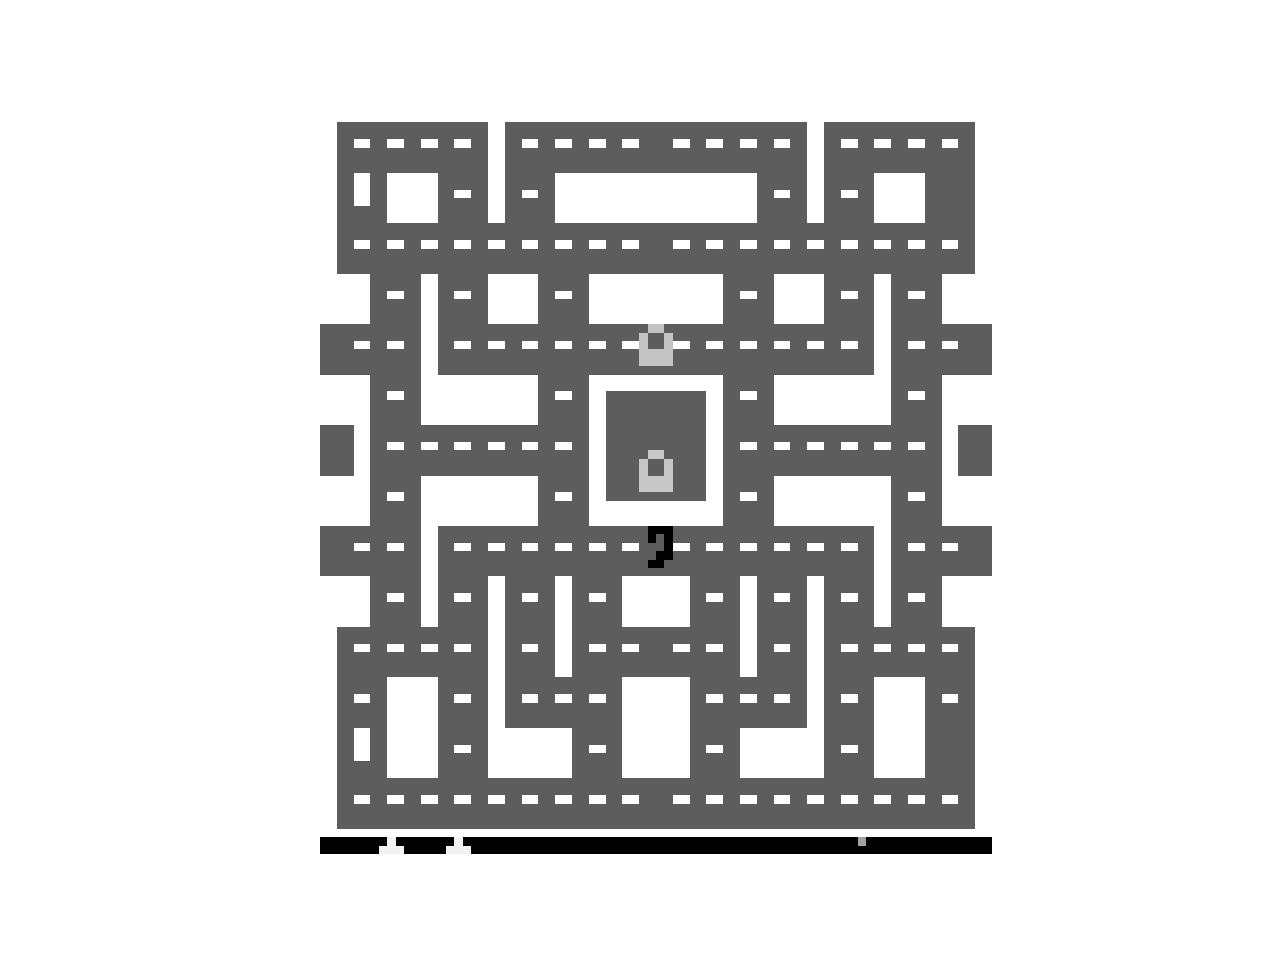

In [5]:
plt.imshow(img.reshape(88,80),interpolation="nearest", cmap="gray")
plt.axis("off")
plt.show()

In [6]:
input_height = 88
input_width = 80
input_channels = 1
conv_n_maps = [32, 64, 64]
conv_kernel_sizes = [(8,8), (4,4), (3,3)]
conv_strides = [4, 2, 1]
conv_paddings = ["SAME"] * 3
conv_activation = [tf.nn.relu] * 3
n_hidden_in = 64 * 11 * 10 # conv3 has 64 maps of 11x10 each
n_hidden = 512
hidden_activation = tf.nn.relu
n_outputs = env.action_space.n # 9 discrete actions are available
initializer = tf.contrib.layers.variance_scaling_initializer()


def q_network(X_state, name):
    prev_layer = X_state
    conv_layers = []
    with tf.variable_scope(name) as scope:
        for n_maps, kernel_size, stride, padding, activation in zip(conv_n_maps, conv_kernel_sizes, conv_strides,
                                                                    conv_paddings, conv_activation):
            prev_layer = tf.layers.conv2d(prev_layer, filters=n_maps, kernel_size=kernel_size,
                                          strides=stride, padding=padding, activation=activation,
                                          kernel_initializer=initializer)
            conv_layers.append(prev_layer)
        last_conv_layer_flat = tf.reshape(prev_layer, shape=[-1, n_hidden_in])
        hidden = tf.layers.dense(last_conv_layer_flat, n_hidden,
                                 activation=hidden_activation,
                                 kernel_initializer=initializer)
        outputs = tf.layers.dense(hidden, n_outputs,
                                  kernel_initializer=initializer)
    trainable_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                       scope=scope.name)
    trainable_vars_by_name = {var.name[len(scope.name):]: var
                              for var in trainable_vars}
    return outputs, trainable_vars_by_name

X_state = tf.placeholder(tf.float32, shape=[None, input_height, input_width, input_channels])

actor_q_values, actor_vars = q_network(X_state, name="q_networks/actor")
critic_q_values, critic_vars = q_network(X_state, name="q_networks/critic")

copy_ops = [actor_var.assign(critic_vars[var_name])
            for var_name, actor_var in actor_vars.items()]
copy_critic_to_actor = tf.group(*copy_ops)

In [7]:
learning_rate = 0.01

X_action = tf.placeholder(tf.int32, shape=[None])
q_value = tf.reduce_sum(critic_q_values * tf.one_hot(X_action, n_outputs), axis=1, keep_dims=True)

y = tf.placeholder(tf.float32, shape=[None, 1])
cost = tf.reduce_mean(tf.square(y - q_value))
global_step = tf.Variable(0, trainable=False, name='global_step')
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(cost, global_step=global_step)
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [8]:
# replay memory

from collections import deque

replay_memory_size = 10000
replay_memory = deque([], maxlen=replay_memory_size)

def sample_memories(batch_size):
    indices = rnd.permutation(len(replay_memory))[:batch_size]
    cols = [[], [], [], [], []] # state, action, reward, next_state, continue
    for idx in indices:
        memory = replay_memory[idx]
        for col, value in zip(cols, memory):
            col.append(value)
    cols = [np.array(col) for col in cols]
    return (cols[0], cols[1], cols[2].reshape(-1, 1), cols[3], cols[4].reshape(-1, 1))

In [9]:
# epsilon greedy policy 

eps_min = 0.05
eps_max = 1.0
eps_decay_steps = 50000

def epsilon_greedy(q_values, step):
    epsilon = max(eps_min, eps_max - (eps_max-eps_min) * step/eps_decay_steps)
    if rnd.rand() < epsilon:
        return rnd.randint(n_outputs) # random action
    else:
        return np.argmax(q_values) # optimal action

In [14]:
n_steps = 100000 # total number of training steps
training_start = 1000 # start training after 1,000 game iterations
training_interval = 3 # run a training step every 3 game iterations
save_steps = 50 # save the model every 50 training steps
copy_steps = 25 # copy the critic to the actor every 25 training steps
discount_rate = 0.95
skip_start = 90 # skip the start of every game (it's just waiting time)
batch_size = 50
iteration = 0 # game iterations
checkpoint_path = "./my_dqn.ckpt"
done = True # env needs to be reset
render = True

from gym.envs.classic_control import rendering
def repeat_upsample(rgb_array, k=1, l=1, err=[]):
    # repeat kinda crashes if k/l are zero
    if k <= 0 or l <= 0: 
        if not err: 
            #print "Number of repeats must be larger than 0, k: {}, l: {}, returning default array!".format(k, l)
            err.append('logged')
        return rgb_array

    # repeat the pixels k times along the y axis and l times along the x axis
    # if the input image is of shape (m,n,3), the output image will be of shape (k*m, l*n, 3)

    return np.repeat(np.repeat(rgb_array, k, axis=0), l, axis=1)

viewer = rendering.SimpleImageViewer()

def render(env):
    rgb = env.render('rgb_array')
    upscaled=repeat_upsample(rgb,4, 4)
    viewer.imshow(upscaled)


with tf.Session() as sess:
    if os.path.isfile(checkpoint_path):
        saver.restore(sess, checkpoint_path)
    else:
        init.run()

    while True:
        step = global_step.eval()
        if step >= n_steps:
            break
            
        iteration += 1
        if done: # game over, start again
            obs = env.reset()
            if render:
                render(env)
            for skip in range(skip_start): # skip the start of each game
                obs, reward, done, info = env.step(0)
                if render:
                    render(env)
            state = preprocess_observation(obs)

        # Actor evaluates what to do
        q_values = actor_q_values.eval(feed_dict={X_state: [state]})
        action = epsilon_greedy(q_values, step)

        # Actor plays
        obs, reward, done, info = env.step(action)
        print(reward)
        if render:
            render(env)
        next_state = preprocess_observation(obs)

        # Let's memorize what just happened
        replay_memory.append((state, action, reward, next_state, 1.0 - done))
        state = next_state
        
        if iteration < training_start or iteration % training_interval != 0:
            continue
            
        # Critic learns
        X_state_val, X_action_val, rewards, X_next_state_val, continues = (
            sample_memories(batch_size))
        next_q_values = actor_q_values.eval(
            feed_dict={X_state: X_next_state_val})
        
        max_next_q_values = np.max(next_q_values, axis=1, keepdims=True)
        y_val = rewards + continues * discount_rate * max_next_q_values
        training_op.run(feed_dict={X_state: X_state_val,
                                    X_action: X_action_val, y: y_val})

        # Regularly copy critic to actor
        if step % copy_steps == 0:
            copy_critic_to_actor.run()
        
        # And save regularly
        if step % save_steps == 0:
            saver.save(sess, checkpoint_path)

0.0
0.0
0.0
0.0
10.0
0.0
0.0
0.0
0.0
0.0
0.0
10.0
0.0
0.0
0.0
0.0
10.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
10.0
0.0
0.0
0.0
0.0
10.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
10.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
10.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
10.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
10.0
0.0
0.0
0.0
0.0
10.0
0.0
0.0
0.0
0.0
10.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
200.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
10.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
10.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
10.0
0.0
0.0
0.0
10.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0

KeyboardInterrupt: 

## bypedal walker

In [2]:

env = gym.make("BipedalWalker-v2")
obs = env.reset()
img = env.render(mode="rgb_array")
obs.dtype

[2017-08-27 19:32:49,626] Making new env: BipedalWalker-v2


dtype('float64')

In [13]:
env.action_space.low

array([-1, -1, -1, -1])

In [8]:
env.action_space.sample()

array([-0.93659358,  0.52318829,  0.61300685,  0.8409612 ])

In [5]:
env.reset()
while True:
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    print("obs", obs, "done", done, "reward", reward, "info", info)
    env.render()
    if done:
        break

obs [-0.02092868 -0.03098655 -0.03129853 -0.0137583   0.47581184  0.99994385
  0.08148968 -1.00062625  1.          0.37759686  0.99953049  0.08691639
 -1.00055122  1.          0.4463037   0.45137215  0.46716911  0.4956468
  0.54075426  0.60996377  0.71798027  0.89696479  1.          1.        ] done False reward -0.222219408292 info {}
obs [-0.0217094  -0.00156421 -0.00471194 -0.02800983  0.47070172 -0.01788757
  0.10745347 -0.38435356  1.          0.39665088  0.25376046 -0.03103602
 -0.99999976  0.          0.44498959  0.45004311  0.46579358  0.49418741
  0.53916204  0.60816777  0.71586627  0.89432377  1.          1.        ] done False reward -0.0820686024548 info {}
obs [-0.01401701  0.01546812  0.00752405  0.019295    0.47407115 -0.18639326
  0.12702012  0.093194    1.          0.36198109 -0.41086179  0.09295845
  0.99999968  0.          0.44588786  0.45095158  0.46673384  0.49518499
  0.54025042  0.60939544  0.71731132  0.89612907  1.          1.        ] done False reward -0.0382

obs [ 0.28975341  0.03433178  0.0675979  -0.00819845  0.45679656 -0.33344448
 -0.673913    0.00144004  1.          0.21874736 -0.34670818 -0.6314286
  0.0299154   1.          0.34998566  0.35396028  0.36634806  0.38867989
  0.42405254  0.47832581  0.56303096  0.70338833  0.97215801  1.        ] done False reward -0.0674170917501 info {}
obs [ 0.29877487  0.01555685  0.06328534  0.00300076  0.45276913  0.00754812
 -0.67394483 -0.16395442  1.          0.19752352 -0.220043   -0.62156343
  0.04290872  1.          0.35080212  0.35478601  0.3672027   0.38958663
  0.42504179  0.47944167  0.56434447  0.70502925  0.97525465  1.        ] done False reward -0.0527201561277 info {}
obs [ 0.31438068  0.02945074  0.07886831  0.02136306  0.44979468  0.00528784
 -0.6407187   0.04335929  0.          0.16472064 -0.37888205 -0.60513282
  0.10854398  1.          0.3523038   0.35630473  0.36877456  0.39125434
  0.42686126  0.48149401  0.56676024  0.70804727  0.98068893  1.        ] done False reward -0.094

obs [ 1.10629749  0.10820034  0.08900155 -0.03114069 -0.0932705  -0.35728166
 -0.61091638  0.          1.         -0.77452052 -1.         -0.63427377
  0.          0.          0.33040679  0.33415905  0.34585384  0.36693639
  0.40033022  0.45156735  0.53153396  0.66403943  0.92237526  1.        ] done False reward -0.258891148078 info {}
obs [ 1.16240382  0.11223996  0.09215072 -0.04078321 -0.14016916 -0.58733714
 -0.6105485   0.          0.         -0.85424978 -1.         -0.57904446
  0.46095498  0.          0.3285245   0.33225539  0.34388354  0.36484599
  0.39804959  0.44899482  0.52850586  0.66025651  0.91674006  1.        ] done False reward -0.24523106865 info {}
obs [ 1.19333863  0.06944983  0.05909321 -0.07808641 -0.10618098  0.36310324
 -0.60793436  0.          0.         -0.8349126   0.         -0.71105862
 -0.99999976  0.          0.32480168  0.32849029  0.33998668  0.3607116
  0.39353892  0.44390684  0.52251685  0.65277451  0.90483606  1.        ] done False reward -0.182447

obs [ 0.96978277 -0.00109991  0.09978866 -0.05412056  0.32747447  0.32295519
 -0.14028072 -1.00000016  1.         -0.66370839 -0.56414908 -0.6213181   0.
  1.          0.31187406  0.31541586  0.32645467  0.34635469  0.37787545
  0.42623866  0.50171989  0.62679303  0.87103206  1.        ] done False reward 0.00817533371969 info {}
obs [ 0.97576636  0.01198068  0.10454463 -0.04076063  0.32998621  0.03198224
 -0.1724174  -0.26814518  1.         -0.68152291 -0.22312951 -0.62339306
 -0.00960889  1.          0.30996844  0.3134886   0.32445997  0.3442384
  0.37556654  0.42363423  0.49865425  0.62296319  0.86543715  1.        ] done False reward 0.00809223793859 info {}
obs [ 1.004125    0.05676033  0.14142493 -0.03670604  0.30189019 -0.33323607
 -0.24484265 -0.61943857  1.         -0.75383371 -0.90590882 -0.59823251
  0.21268737  1.          0.30827293  0.31177384  0.32268518  0.34235543
  0.37351221  0.42131698  0.49592662  0.61955565  0.86074919  1.        ] done False reward -0.09487296705

obs [ 0.6529302  -0.05708257  0.12256515 -0.1177245   0.91776597 -0.19515434
  0.00210965  0.99999968  0.         -0.77211887  0.60003179 -0.67883229
 -0.99999968  0.          0.27272436  0.27582157  0.28547466  0.30287662
  0.33044055  0.3727327   0.43873873  0.54811144  0.76173997  1.        ] done False reward 0.155436611715 info {}
obs [ 0.6207059  -0.0674784   0.12343353 -0.00833993  0.89497268 -0.22901186
  0.11938798  0.93210332  0.         -0.76135975  0.2782352  -0.63671517
  0.06491477  1.          0.27268082  0.27577752  0.28542909  0.30282828
  0.3303878   0.37267321  0.4386687   0.54802394  0.76243329  1.        ] done False reward 0.196314186321 info {}
obs [ 0.59585953 -0.04974566  0.16899435  0.0241172   0.94185835  0.60981005
  0.00297129 -1.00024509  0.         -0.7674464  -0.05639297 -0.50035024
  1.00043837  1.          0.27374789  0.27685672  0.28654605  0.30401331
  0.33168069  0.37413156  0.44038531  0.55016845  0.76702362  1.        ] done False reward 0.1969633

   4.40717131e-01   5.50583005e-01   7.78901756e-01   1.00000000e+00] done False reward -0.0805162250776 info {}
obs [ 0.46070221  0.01160029  0.02262642  0.03399658  1.09287179 -0.17574033
 -0.61822915  0.03589948  0.         -0.7735436  -0.29366037 -0.29483318
  0.24694069  1.          0.27554846  0.27867773  0.28843081  0.30601296
  0.3338623   0.3765924   0.44328192  0.55378717  0.78393573  1.        ] done False reward -0.0625978904999 info {}
obs [ 0.44011512 -0.04114319 -0.02047847  0.01369707  1.12793946  0.4841767
 -0.49458265  1.00000032  0.         -0.69460928  0.99999982 -0.41098464
 -1.00000008  0.          0.27612031  0.27925608  0.28902939  0.30664802
  0.33455518  0.37737396  0.44420189  0.55493647  0.7856307   1.        ] done False reward -0.00478909615944 info {}
obs [ 0.4175902  -0.04506679 -0.02929844  0.03200211  1.12269425 -0.04747486
 -0.38928914  0.86107063  0.         -0.64906985  0.58614409 -0.52901733
 -0.99968259  0.          0.27755001  0.28070202  0.29052

obs [ 0.42075518 -0.02836266 -0.04666074  0.0150424   1.04812908 -0.77074605
 -0.53592336  0.70194054  1.         -0.67887384 -0.39569372 -0.41944933
  0.07191883  0.          0.27967978  0.28285596  0.29275528  0.31060103
  0.33886793  0.38223869  0.44992808  0.56209016  0.79279315  1.        ] done False reward -0.0202763350199 info {}
obs [ 0.40162387 -0.03776759 -0.06197633 -0.00926457  1.13327456  0.29178569
 -0.59216619  0.06403188  1.         -0.6600644   0.26437613 -0.53595781
 -1.00000016  0.          0.27908272  0.28225213  0.29213029  0.30993795
  0.33814451  0.38142267  0.44896758  0.5608902   0.79069084  1.        ] done False reward 0.0222580085708 info {}
obs [  4.02651310e-01   2.04470143e-03  -6.88344884e-02  -4.51875508e-03
   1.13413811e+00   1.48108229e-05  -5.84328651e-01   7.27573584e-02
   1.00000000e+00  -6.76104844e-01  -1.68303013e-01  -6.53141618e-01
  -9.99998172e-01   0.00000000e+00   2.78871000e-01   2.82038003e-01
   2.91908681e-01   3.09702843e-01   3.37

obs [  7.58627236e-01   6.94509566e-03  -1.25024943e-01  -2.11527753e-02
   1.13071203e+00   2.98023224e-08  -4.92196321e-01   1.00000016e+00
   0.00000000e+00  -7.54599631e-01   9.99999762e-01  -6.14925146e-01
   0.00000000e+00   0.00000000e+00   2.71895111e-01   2.74982899e-01
   2.84606665e-01   3.01955700e-01   3.29435825e-01   3.71599376e-01
   4.37404692e-01   5.46444833e-01   7.54682243e-01   1.00000000e+00] done False reward -0.188272278485 info {}
obs [ 0.76324946  0.00923563 -0.06895889  0.01716773  1.12911987 -0.00324969
 -0.37069929  0.99948025  0.         -0.75067639  0.05295118 -0.62878883
 -0.03540152  1.          0.27270979  0.27580681  0.28545943  0.30286044
  0.33042291  0.37271279  0.43871528  0.54808211  0.75691557  1.        ] done False reward -0.139824031697 info {}
obs [  7.70269573e-01   1.40647745e-02  -4.44919574e-02   2.15692711e-02
   1.12717986e+00   5.12033701e-04  -4.65816498e-01  -8.12553406e-01
   0.00000000e+00  -7.52912700e-01  -2.77253911e-02  -6.23

obs [  7.78728485e-01   1.29531789e-02  -5.24501324e-02  -1.06023347e-02
   7.78237402e-01  -4.33337212e-01   1.69769526e-01   1.00031614e+00
   0.00000000e+00  -8.13828826e-01   1.26659870e-06  -6.35342479e-01
   1.30522052e-02   1.00000000e+00   2.70508945e-01   2.73580998e-01
   2.83155680e-01   3.00416291e-01   3.27756286e-01   3.69704902e-01
   4.35174733e-01   5.43658972e-01   7.46524513e-01   1.00000000e+00] done False reward -0.13567335774 info {}
obs [ 0.76518607 -0.02715227 -0.05956644  0.01241982  0.82724553  0.61235929
  0.15920836 -0.09760276  0.         -0.79047883  0.2928896  -0.63560879
  0.00256283  1.          0.27106729  0.27414566  0.28374013  0.30103636
  0.3284328   0.37046799  0.43607295  0.54478109  0.74806541  1.        ] done False reward -0.0353345169638 info {}
obs [ 0.75984973 -0.01081664 -0.0419247   0.01115497  0.89528668  0.86422497
  0.04398328 -1.00010157  0.         -0.77908099  0.1469712  -0.63460147
 -0.01213606  1.          0.27158174  0.27466595  

  0.33768728  0.38090691  0.44836047  0.56013173  0.76914412  1.        ] done False reward -0.204599990675 info {}
obs [ 0.54502624  0.02780516 -0.0846836  -0.01198928  0.96313381  0.35531944
 -0.07871497 -0.99999984  1.         -0.84736758 -0.95246315 -0.31950223
  1.00000008  0.          0.2781671   0.28132612  0.29117188  0.30892113
  0.33703515  0.3801713   0.4474946   0.55905002  0.76765877  1.        ] done False reward -0.177034650257 info {}
obs [ 0.56112891  0.03749466 -0.12891605 -0.01400159  0.88570547 -0.99999976
  0.04335773  0.72011073  1.         -0.83491099  0.         -0.44922829
 -1.00000032  0.          0.27757907  0.28073141  0.29055634  0.30826807
  0.33632267  0.37936765  0.44654861  0.55786824  0.76603597  1.        ] done False reward -0.251428517342 info {}
obs [ 0.5845319   0.0472001  -0.17435958 -0.00173962  0.84562081 -0.70772851
  0.14722586  0.99999936  1.         -0.82611233  0.12023005 -0.5672127  -1.
  0.          0.27753597  0.28068781  0.29051122  0.

obs [ 0.8653357  -0.04771157 -0.05153771 -0.01534541  0.75494868  0.60572809
  0.23055351  1.00000016  0.         -0.83490759  0.         -0.63162255
 -0.24314908  1.          0.27970338  0.28287983  0.29277998  0.31062725
  0.33889654  0.38227093  0.44996604  0.5621376   0.77189845  1.        ] done False reward 0.0130315789824 info {}
obs [ 0.85882151 -0.01232935 -0.0289635  -0.00107991  0.73290569 -0.26984322
  0.35320783  0.99995581  0.         -0.81431174  0.06367159 -0.59999764
 -0.00375762  1.          0.27952796  0.28270242  0.29259634  0.31043243
  0.33868399  0.3820312   0.44968385  0.56178504  0.77141434  1.        ] done False reward -0.0504111569372 info {}
obs [  8.60550046e-01   3.43684226e-03  -1.43629807e-02   2.40117952e-03
   6.79558456e-01  -6.49280965e-01   4.76066768e-01   9.99999921e-01
   0.00000000e+00  -8.14308167e-01   1.86264515e-09  -6.01675749e-01
  -5.82205628e-03   1.00000000e+00   2.79641509e-01   2.82817274e-01
   2.92715192e-01   3.10558528e-01   3.38

obs [ 0.23097822 -0.10341695  0.08926461  0.01353014  0.95921415  1.07123327
  0.80910927 -1.00000016  0.         -0.55645579  0.28697735 -0.39155698
  1.00000016  0.          0.27825928  0.28141934  0.29126835  0.3090235
  0.33714682  0.38029727  0.44764289  0.55923527  0.76791316  1.        ] done False reward 0.295542949325 info {}
obs [ 0.20189166 -0.05818534  0.11074182 -0.01312693  1.04447532  1.08291256
  0.70650619 -0.99414062  1.         -0.62075657 -0.79600865 -0.2464087
  1.17564297  0.          0.27750567  0.28065717  0.29047951  0.30818656
  0.33623374  0.37926733  0.44643053  0.55772072  0.76583338  1.        ] done False reward 0.173022112122 info {}
obs [ 0.16561316 -0.07269542  0.09501498 -0.01204709  1.04926109  0.07857886
  0.82543361  1.          1.         -0.62936354 -0.08145311 -0.11886597
  0.99999992  0.          0.27678683  0.27993017  0.28972706  0.30738825
  0.33536276  0.3782849   0.44527414  0.55627602  0.76384962  1.        ] done False reward 0.174650621

obs [ 0.10180422 -0.00937228  0.04775846  0.00235497  1.11823177 -0.20865154
  0.91240716  0.          0.         -0.64615506 -0.32439908 -0.36824059
 -0.99999984  1.          0.2634905   0.26648283  0.27580911  0.29262188
  0.31925255  0.36011279  0.42388397  0.52955353  0.72715569  1.        ] done False reward -0.0102065164875 info {}
obs [ 0.10956412  0.01557453  0.07215925  0.00777228  1.07012272 -0.59359461
  0.96275949  1.09705416  1.         -0.72658092 -1.00000012 -0.24594474
  0.99999968  0.          0.26386485  0.26686144  0.27620095  0.29303762
  0.31970611  0.3606244   0.42448619  0.53030586  0.72818875  1.        ] done False reward -0.0567075890024 info {}
obs [ 0.10676011 -0.00501313  0.04904259 -0.02268558  1.12202692  0.79209399
  0.82662106 -1.00028515  1.         -0.80701119 -0.99978918 -0.11795926
  1.0000728   0.          0.26281494  0.26579961  0.27510196  0.29187164
  0.31843403  0.35918948  0.42279717  0.52819586  0.72529131  1.        ] done False reward -0.02

obs [ 0.1626934   0.07669738  0.02562237 -0.02539435  1.09749901 -0.36788416
  0.92015111  0.20128198  1.         -0.85185653 -0.99999988 -0.48169529
  0.21032564  0.          0.24187557  0.24462242  0.25318363  0.26861721
  0.29306328  0.33057162  0.38911146  0.48611262  0.66750485  1.        ] done False reward -0.228630139386 info {}
obs [ 0.18417314  0.04985041 -0.00416536 -0.01782805  1.06143785 -0.29373306
  0.91961753  0.          1.         -0.83491176  0.         -0.46211112
  0.1765396   1.          0.24129076  0.24403097  0.25257149  0.26796773
  0.2923547   0.32977235  0.38817066  0.48493731  0.66589093  1.        ] done False reward -0.185930050799 info {}
obs [  1.71483368e-01  -1.57045269e-02  -1.20385391e-02  -3.16416882e-04
   1.08136630e+00   2.07908824e-01   9.22059655e-01   0.00000000e+00
   1.00000000e+00  -8.36282551e-01   6.03497028e-07  -3.39013934e-01
   9.99500672e-01   1.00000000e+00   2.41630420e-01   2.44374484e-01
   2.52927035e-01   2.68344939e-01   2.927

   3.86224478e-01   4.82505947e-01   6.62552357e-01   1.00000000e+00] done False reward -0.174767392297 info {}
obs [  1.10423848e-01   2.13247240e-03  -7.56008327e-03  -4.83202696e-03
   1.13337946e+00  -6.92356890e-03   9.34204698e-01  -1.94794188e-03
   1.00000000e+00  -8.34121943e-01   1.84342265e-04   1.07893825e-01
  -2.02728560e-02   1.00000000e+00   2.39847198e-01   2.42571011e-01
   2.51060426e-01   2.66364574e-01   2.90605634e-01   3.27799439e-01
   3.85848373e-01   4.82036084e-01   6.61907136e-01   1.00000000e+00] done False reward -0.0648688567573 info {}
obs [  1.10430166e-01   1.56040839e-05  -3.58728552e-05  -1.66613441e-04
   1.13339520e+00   1.52929351e-04   9.34210062e-01   7.17861500e-06
   1.00000000e+00  -8.34195435e-01  -1.94285531e-06   1.08182132e-01
  -6.38727894e-05   1.00000000e+00   2.39838883e-01   2.42562607e-01
   2.51051724e-01   2.66355336e-01   2.90595561e-01   3.27788085e-01
   3.85834992e-01   4.82019365e-01   6.61884189e-01   1.00000000e+00] done Fa

obs [  1.30170837e-01  -1.23522198e-02   5.24500895e-02   4.76120043e-02
   1.13490748e+00   2.98023224e-08   8.66792560e-01   4.67926423e-01
   1.00000000e+00  -8.04594994e-01   0.00000000e+00   6.74139857e-02
   9.99999364e-01   0.00000000e+00   2.48711541e-01   2.51536012e-01
   2.60339200e-01   2.76208937e-01   3.01345944e-01   3.39914352e-01
   4.00108665e-01   4.99851316e-01   6.86370075e-01   1.00000000e+00] done False reward -0.0145040723035 info {}
obs [  1.34232417e-01   8.54909837e-03   4.36400485e-02   4.11577797e-02
   1.12445605e+00   5.04180789e-05   8.32699537e-01  -1.67768061e-01
   1.00000000e+00  -8.06595922e-01  -4.58210707e-07   5.14613986e-02
  -3.56255819e-02   1.00000000e+00   2.50684649e-01   2.53531545e-01
   2.62404561e-01   2.78400213e-01   3.03736627e-01   3.42611015e-01
   4.03282881e-01   5.03816843e-01   6.91815317e-01   1.00000000e+00] done False reward -0.0508914320918 info {}
obs [ 0.12454513 -0.01908112  0.020606    0.04215997  1.09268558 -0.4040353


  0.29432768  0.33199784  0.39079025  0.48820993  0.67038476  1.        ] done False reward 0.00393147221778 info {}
obs [  1.13020584e-01  -1.83819795e-02  -4.89256561e-03   5.06018496e-02
   1.13165784e+00   4.47034836e-08   9.43995833e-01   6.04541143e-01
   1.00000000e+00  -8.02675068e-01   0.00000000e+00   2.01454759e-02
   4.77945050e-01   0.00000000e+00   2.45254979e-01   2.48040214e-01
   2.56721050e-01   2.72370219e-01   2.97157854e-01   3.35190266e-01
   3.94547999e-01   4.92904425e-01   6.76831007e-01   1.00000000e+00] done False reward -0.0309539605226 info {}
obs [ 0.10918198 -0.00766507 -0.00208365  0.04484674  1.11556637 -0.01968006
  0.92374218  0.          1.         -0.80514604  0.          0.08235073
 -0.1808298   1.          0.24735622  0.25016531  0.25892052  0.2747038
  0.29970378  0.33806202  0.39792833  0.49712744  0.68262982  1.        ] done False reward -0.0250869247132 info {}
obs [  1.04158357e-01  -9.73376095e-03  -1.98339289e-02   3.97236538e-02
   1.1156

obs [  1.65896907e-01  -1.96062982e-02   3.73152280e-02  -8.25260699e-03
   1.11597419e+00   8.60111415e-01   8.16300988e-01  -9.99915441e-01
   1.00000000e+00  -8.28580260e-01   5.71459532e-06  -9.84559059e-02
   1.00134595e+00   1.00000000e+00   2.46529385e-01   2.49329090e-01
   2.58055031e-01   2.73785532e-01   2.98701972e-01   3.36931974e-01
   3.96598160e-01   4.95465696e-01   6.80347979e-01   1.00000000e+00] done False reward 0.0194333605286 info {}
obs [  1.45454347e-01  -4.09854174e-02   2.67877007e-02   2.43845344e-02
   1.11574936e+00  -4.01079655e-04   9.10061359e-01   7.78380315e-01
   1.00000000e+00  -7.96571076e-01   4.25879061e-01  -2.17323780e-01
  -9.95666742e-01   1.00000000e+00   2.47592345e-01   2.50404119e-01
   2.59167671e-01   2.74966031e-01   2.99989879e-01   3.38384748e-01
   3.98308188e-01   4.97601986e-01   6.83281422e-01   1.00000000e+00] done False reward 0.0542355819047 info {}
obs [  1.45966217e-01   8.22864771e-04   3.33374763e-02   1.18131483e-02
   1.

obs [  1.83227941e-01   2.95712829e-02  -3.08723366e-02   4.87512922e-02
   1.10399604e+00  -3.51667404e-06   7.74400353e-01  -3.83549730e-01
   1.00000000e+00  -8.07212472e-01   3.57627869e-07  -2.01102495e-01
   8.32417250e-01   0.00000000e+00   2.50154465e-01   2.52995342e-01
   2.61849582e-01   2.77811408e-01   3.03094238e-01   3.41886401e-01
   4.02429968e-01   5.02751291e-01   6.90352201e-01   1.00000000e+00] done False reward -0.183069516932 info {}
obs [ 0.19613139  0.02571477 -0.03629261  0.0539065   1.03428328 -0.86983919
  0.89494729  1.          1.         -0.8055414   0.06974339 -0.07513666
  1.00000008  0.          0.25270507  0.25557491  0.26451945  0.28064403
  0.30618462  0.34537232  0.40653318  0.50787741  0.69739109  1.        ] done False reward -0.137611018435 info {}
obs [ 0.19764394  0.00301541 -0.03670036  0.02176383  1.01416361 -0.25239533
  1.01463223  1.          0.         -0.80780542  0.         -0.00794268
 -0.01257066  0.          0.25371948  0.25660086  

obs [  1.58744320e-01   4.84236145e-02   4.21675372e-02   7.04432666e-03
   1.13490713e+00  -8.04662704e-07   8.22860718e-01  -4.60196654e-01
   1.00000000e+00  -8.76612484e-01  -9.99963105e-01  -6.09215021e-01
   4.63326772e-05   0.00000000e+00   2.42382064e-01   2.45134667e-01
   2.53713816e-01   2.69179702e-01   2.93676972e-01   3.31263840e-01
   3.89926285e-01   4.87130553e-01   6.68902636e-01   1.00000000e+00] done False reward -0.159345896296 info {}
obs [  1.69538885e-01   3.70548368e-02   3.05533934e-02   2.35881686e-02
   1.06263185e+00  -9.99993145e-01   9.43720341e-01   1.00000032e+00
   0.00000000e+00  -8.34923208e-01  -1.34110451e-07  -6.34939432e-01
  -7.74860382e-07   0.00000000e+00   2.43807301e-01   2.46576086e-01
   2.55205691e-01   2.70762503e-01   2.95403808e-01   3.33211720e-01
   3.92219096e-01   4.89994943e-01   6.72835827e-01   1.00000000e+00] done False reward -0.101219758202 info {}
obs [ 0.17222102  0.00637921  0.04084072 -0.0026924   1.07342505  0.09429079
 

obs [ 0.19706699 -0.01096688  0.01041681 -0.01827363  1.12069523  0.28789929
  0.87284088  0.99920257  0.         -0.80092007 -0.05277982 -0.65951085
 -0.76279521  1.          0.2500065   0.2528457   0.2616947   0.27764711
  0.30291495  0.34168419  0.40219191  0.50245386  0.68994385  1.        ] done False reward 0.000245364935053 info {}
obs [  2.09993035e-01   2.49165559e-02   1.96497953e-02  -7.07902789e-03
   1.11944103e+00   0.00000000e+00   7.87923098e-01  -7.23188639e-01
   0.00000000e+00  -8.06194723e-01   0.00000000e+00  -6.34907484e-01
  -1.98682149e-08   0.00000000e+00   2.49746874e-01   2.52583116e-01
   2.61422932e-01   2.77358741e-01   3.02600384e-01   3.41329336e-01
   4.01774228e-01   5.01932085e-01   6.89227343e-01   1.00000000e+00] done False reward -0.112904482559 info {}
obs [  2.01348886e-01  -1.73041356e-02   1.65655071e-02   9.17886496e-03
   1.11911964e+00   2.62856483e-05   7.41630912e-01  -3.90322487e-01
   0.00000000e+00  -8.08053851e-01  -3.44961882e-06  -5.

  0.28862086  0.32556063  0.3832131   0.47874385  0.65738642  1.        ] done False reward 0.0745404187887 info {}
obs [  1.14940725e-01  -7.38489628e-03   1.03041463e-03   2.12393627e-03
   1.13259482e+00   4.97378334e-02   9.34906483e-01   1.66196190e-02
   1.00000000e+00  -8.33036840e-01  -1.26583874e-03  -3.66041660e-01
   5.82188090e-01   1.00000000e+00   2.38273457e-01   2.40979403e-01
   2.49413118e-01   2.64616847e-01   2.88698852e-01   3.25648606e-01
   3.83316636e-01   4.78873223e-01   6.57564104e-01   1.00000000e+00] done False reward -0.0393703680417 info {}
obs [  1.15568951e-01   1.49298772e-03  -4.24440444e-03  -1.50819615e-03
   1.13247335e+00  -7.58434925e-03   9.34315681e-01  -1.41694862e-03
   1.00000000e+00  -8.34907293e-01   1.47032551e-04  -2.43486524e-01
   1.00056012e+00   0.00000000e+00   2.38202110e-01   2.40907252e-01
   2.49338433e-01   2.64537603e-01   2.88612396e-01   3.25551093e-01
   3.83201867e-01   4.78729844e-01   6.57367170e-01   1.00000000e+00] don

obs [  1.28930554e-01   3.49906266e-03  -1.53812045e-02   9.51781988e-03
   1.10799336e+00  -1.41505152e-05   9.28404570e-01  -5.14497012e-02
   1.00000000e+00  -8.16249013e-01   1.42492354e-06   6.56488538e-02
  -1.45803479e-02   1.00000000e+00   2.43397012e-01   2.46161148e-01
   2.54776210e-01   2.70306855e-01   2.94906706e-01   3.32650959e-01
   3.91559035e-01   4.89170372e-01   6.71703577e-01   1.00000000e+00] done False reward -0.058652064524 info {}
obs [  1.34883419e-01   1.19177401e-02  -2.02909791e-02   1.42074633e-02
   1.10801053e+00   5.56930900e-05   9.12012577e-01  -1.36696825e-01
   1.00000000e+00  -8.16255629e-01  -5.61028719e-06   6.07771873e-02
  -5.00725160e-02   1.00000000e+00   2.44082496e-01   2.46854410e-01
   2.55493730e-01   2.71068126e-01   2.95737237e-01   3.33587825e-01
   3.92661810e-01   4.90548015e-01   6.73595309e-01   1.00000000e+00] done False reward -0.101813232566 info {}
obs [  1.34162977e-01  -1.45185024e-03  -3.41152690e-03   1.77710652e-02
   1.

obs [ 0.32949945  0.0155882  -0.01789106  0.00514635  1.02812922 -0.62206453
  0.64175344  1.          0.         -0.81528437  0.         -0.64930236
 -0.99999984  0.          0.26225123  0.26522949  0.2745119   0.29124561
  0.31775102  0.35841906  0.42189032  0.52706289  0.72373569  1.        ] done False reward -0.0986566955294 info {}
obs [  3.23575258e-01  -1.24645495e-02  -1.90266877e-02   7.56337106e-03
   9.88588035e-01  -4.86487508e-01   7.63826489e-01   1.00000000e+00
   0.00000000e+00  -7.64731169e-01   6.77594781e-01  -6.34907961e-01
  -3.97364299e-08   0.00000000e+00   2.62590528e-01   2.65572637e-01
   2.74867058e-01   2.91622400e-01   3.18162113e-01   3.58882785e-01
   4.22436178e-01   5.27744830e-01   7.24672019e-01   1.00000000e+00] done False reward -0.0299915516212 info {}
obs [ 0.32868364  0.00985035 -0.00279627 -0.00480455  0.99524158  0.10412298
  0.64734209 -0.99999706  0.         -0.77219617 -0.07049116 -0.617589
  0.00385892  1.          0.26241493  0.26539505  

  0.30486172  0.34388012  0.40477672  0.50568306  0.69437796  1.        ] done False reward -0.0892113423708 info {}
obs [  2.09494889e-01   4.13083524e-03  -7.29584210e-04  -3.61736846e-02
   1.05975604e+00  -5.79344407e-02   9.73335266e-01   9.99999921e-01
   0.00000000e+00  -8.34907830e-01   0.00000000e+00  -7.08222389e-02
  -7.08155394e-01   0.00000000e+00   2.49921039e-01   2.52759248e-01
   2.61605233e-01   2.77552158e-01   3.02811384e-01   3.41567367e-01
   4.02054429e-01   5.02282083e-01   6.89707994e-01   1.00000000e+00] done False reward -0.06657644625 info {}
obs [  2.03674540e-01  -1.06128967e-02   3.49396098e-02  -2.87477517e-02
   1.14199281e+00   8.78323138e-01   9.34908628e-01   0.00000000e+00
   0.00000000e+00  -8.35183680e-01   1.28224492e-05  -1.18304849e-01
  -3.63628983e-01   1.00000000e+00   2.48577878e-01   2.51400858e-01
   2.60199279e-01   2.76060522e-01   3.01183969e-01   3.39731663e-01
   3.99893641e-01   4.99582678e-01   6.86001241e-01   1.00000000e+00] done

  0.30244178  0.34115043  0.40156367  0.50166905  0.68886608  1.        ] done False reward -0.0118343842904 info {}
obs [  1.19161457e-01   7.95639396e-03   5.05998865e-03  -3.05643415e-02
   1.13490677e+00   7.45058060e-09   9.25189495e-01   0.00000000e+00
   0.00000000e+00  -8.15631688e-01   2.66759694e-01   3.04668546e-02
  -9.99999921e-01   1.00000000e+00   2.48213366e-01   2.51032203e-01
   2.59817719e-01   2.75655687e-01   3.00742328e-01   3.39233488e-01
   3.99307251e-01   4.98850107e-01   6.84995294e-01   1.00000000e+00] done False reward -0.0756850737382 info {}
obs [  1.27041116e-01   1.57686591e-02   7.63010323e-03  -5.24662066e-02
   1.13490689e+00  -1.49011612e-08   9.25253630e-01   0.00000000e+00
   0.00000000e+00  -8.17821503e-01   0.00000000e+00  -8.54864120e-02
  -9.99999762e-01   0.00000000e+00   2.45773718e-01   2.48564839e-01
   2.57264018e-01   2.72946328e-01   2.97786385e-01   3.35899204e-01
   3.95382524e-01   4.93946970e-01   6.78262591e-01   1.00000000e+00] do

obs [ 0.18836609  0.05463533  0.01459133  0.02674681  1.08557451 -0.60419428
  0.77525103  0.60584605  1.         -0.71981859 -0.66927481 -0.44475973
  0.78204656  1.          0.26160875  0.26457971  0.27383938  0.29053208
  0.31697258  0.35754099  0.42085677  0.52577168  0.72196263  1.        ] done False reward -0.147148682699 info {}
obs [ 0.21099043  0.04520482 -0.00318749  0.00546136  1.09464538  0.12888011
  0.65773338 -0.99999984  0.         -0.72248459 -0.03070718 -0.48540688
 -0.34407794  0.          0.2619383   0.26491302  0.27418435  0.29089808
  0.31737188  0.3579914   0.42138693  0.526434    0.72287208  1.        ] done False reward -0.153362317256 info {}
obs [ 0.22610033  0.03007719  0.01350379 -0.0118902   1.13275695  0.49459448
  0.54206383 -1.00000016  1.         -0.75240541 -0.35096544 -0.36318874
  0.99999984  0.          0.2614243   0.26439318  0.27364632  0.29032725
  0.3167491   0.3572889   0.42056003  0.525401    0.72145361  1.        ] done False reward -0.1031

obs [  2.61916220e-01   2.19069600e-02   2.40143873e-03   1.34398961e-02
   9.90895629e-01  -3.34773540e-01   8.05029035e-01   1.10945801e-02
   0.00000000e+00  -8.03728163e-01  -1.47521496e-06  -3.03005934e-01
  -9.97866869e-01   0.00000000e+00   2.56233245e-01   2.59143174e-01
   2.68212557e-01   2.84562260e-01   3.10459465e-01   3.50194275e-01
   4.12209034e-01   5.14968157e-01   7.07127810e-01   1.00000000e+00] done False reward -0.10370846325 info {}
obs [  2.72450715e-01   2.08427453e-02  -4.56132844e-03   9.34567213e-03
   1.03264487e+00   5.39334655e-01   6.98814809e-01  -9.95603879e-01
   1.00000000e+00  -8.08065355e-01  -1.34110451e-07  -4.28468108e-01
  -1.00006604e+00   0.00000000e+00   2.56710947e-01   2.59626299e-01
   2.68712610e-01   2.85092771e-01   3.11038256e-01   3.50847155e-01
   4.12977546e-01   5.15928268e-01   7.08446145e-01   1.00000000e+00] done False reward -0.126920366556 info {}
obs [  2.89113492e-01   3.32594562e-02  -8.95061910e-03   1.48409414e-02
   9.6

obs [  4.42610115e-01  -4.27693427e-03  -6.21162701e-02   2.84805804e-03
   1.08148611e+00  -1.65213943e-01   5.34138680e-02   1.00011587e+00
   1.00000000e+00  -8.24122190e-01   3.94880772e-07  -3.13645482e-01
   9.99886592e-01   1.00000000e+00   2.67669827e-01   2.70709634e-01
   2.80183822e-01   2.97263265e-01   3.24316353e-01   3.65824670e-01
   4.30607378e-01   5.37953019e-01   7.38689423e-01   1.00000000e+00] done False reward -0.115268758817 info {}
obs [ 0.45005572  0.0148423  -0.0601153   0.01459272  1.0459981  -0.41616058
  0.17679673  1.00001494  0.         -0.81500119  0.13560054 -0.43281877
 -0.99878844  1.          0.26837659  0.27142441  0.28092363  0.29804817
  0.32517266  0.36679059  0.43174437  0.53937346  0.74063987  1.        ] done False reward -0.129398650417 info {}
obs [  4.53938752e-01   7.67449081e-03  -4.64906073e-02   2.12674999e-02
   9.98528302e-01  -5.79097807e-01   2.99656808e-01   9.99969800e-01
   0.00000000e+00  -8.17576528e-01   3.94880772e-07  -3.09

obs [ 0.47225475  0.01816381 -0.0699593  -0.00561277  0.9654097  -0.73250341
  0.1948244   1.00012414  0.         -0.66433823 -0.01680096 -0.59122682
  0.01565879  1.          0.27544814  0.27857628  0.28832579  0.30590156
  0.33374077  0.37645531  0.44312054  0.55358559  0.76015526  1.        ] done False reward -0.141083174084 info {}
obs [ 0.50689167  0.06908718 -0.02982985 -0.01643576  0.89800048 -0.78584301
  0.29659384  0.9765114   1.         -0.74433321 -1.00000024 -0.48341846
  0.99999968  1.          0.27478841  0.27790904  0.28763521  0.30516887
  0.33294141  0.37555364  0.44205922  0.55225968  0.75833458  1.        ] done False reward -0.290644555821 info {}
obs [ 0.54306251  0.07455889 -0.0629724  -0.01746595  0.83801508 -1.00242937
  0.3336187   1.00120465  1.         -0.82185584 -0.99977911 -0.3638047
  1.00007264  1.          0.2741344   0.27724761  0.28695062  0.30444255
  0.332149    0.37465981  0.44100708  0.55094528  0.75652969  1.        ] done False reward -0.30329

obs [ 0.45883578 -0.02121292 -0.03763944  0.03510201  0.93606496 -0.07380025
  0.63411278  1.          0.         -0.65701133 -0.5451417  -0.54252672
  0.99999968  0.          0.28120622  0.28439975  0.29435307  0.31229624
  0.34071743  0.38432488  0.45238373  0.56515795  0.7760458   1.        ] done False reward -0.0479518852566 info {}
obs [ 0.43892983 -0.03991676 -0.03709327  0.00868507  1.00693882  0.89044243
  0.58556896 -0.42057319  0.         -0.68431741 -0.3291505  -0.41983652
  1.00000008  0.          0.28154284  0.28474018  0.29470542  0.31267008
  0.34112528  0.38478494  0.45292524  0.56583446  0.7769748   1.        ] done False reward 0.0521630869434 info {}
obs [ 0.4279941  -0.02192543 -0.0252275  -0.01391383  1.08539867  1.00000036
  0.47002655 -0.99999992  0.         -0.74878711 -0.79758257 -0.29641891
  1.00000008  0.          0.28083608  0.2840254   0.29396561  0.31188518
  0.34026894  0.38381901  0.45178825  0.56441402  0.77502435  1.        ] done False reward -0.032

obs [  2.18259677e-01  -4.54544693e-03   1.56193918e-02   1.87130141e-02
   1.11407077e+00  -2.68126465e-03   8.17250490e-01  -1.00024454e+00
   0.00000000e+00  -8.34907532e-01   8.68421048e-05  -3.26763391e-01
   1.00177360e+00   1.00000000e+00   2.50309050e-01   2.53151685e-01
   2.62011409e-01   2.77983099e-01   3.03281546e-01   3.42097670e-01
   4.02678639e-01   5.03061950e-01   6.90778792e-01   1.00000000e+00] done False reward -0.072874624825 info {}
obs [  2.12943479e-01  -9.95742679e-03   1.42247316e-02   6.30276799e-03
   1.11294377e+00  -1.53252482e-03   7.01097846e-01  -1.00015505e+00
   0.00000000e+00  -8.34906936e-01   4.97214496e-05  -2.06182003e-01
   1.00092173e+00   1.00000000e+00   2.50583977e-01   2.53429741e-01
   2.62299180e-01   2.78288424e-01   3.03614646e-01   3.42473418e-01
   4.03120935e-01   5.03614485e-01   6.91537499e-01   1.00000000e+00] done False reward -0.021629764354 info {}
obs [ 0.20141572 -0.02307704  0.00571027  0.02056001  1.11023974 -0.00262287
 

obs [ 0.1172278  -0.00340539  0.0339277  -0.01584116  1.13441563 -0.00344512
  0.93490767  0.          0.         -0.69525117  0.1006948  -0.57574546
 -0.99847213  1.          0.25206473  0.25492731  0.26384917  0.27993289
  0.30540878  0.34449717  0.40550306  0.50659049  0.69562393  1.        ] done False reward -0.0286857671572 info {}
obs [ 0.10439645 -0.02597736  0.03684978  0.00349538  1.13413143  0.00178105
  0.93490672  0.          0.         -0.67923343  0.268397   -0.69016147
 -1.00002893  1.          0.25222379  0.25508818  0.26401567  0.28010952
  0.30560148  0.34471455  0.40575895  0.50691015  0.69606292  1.        ] done False reward 0.0272230173002 info {}
obs [  1.13046914e-01   1.57623780e-02   6.45188856e-02  -1.67343950e-02
   1.09835100e+00  -4.31041092e-01   9.34906602e-01   0.00000000e+00
   0.00000000e+00  -7.70064294e-01  -9.99999762e-01  -6.34908080e-01
   3.97364299e-08   1.00000000e+00   2.51516849e-01   2.54373193e-01
   2.63275683e-01   2.79324442e-01   3.04

   3.89181942e-01   4.86200690e-01   6.67625785e-01   1.00000000e+00] done False reward -0.0171535978292 info {}
obs [  1.33078158e-01  -2.18044400e-03  -2.44308865e-02   5.84652901e-03
   1.11724925e+00   5.54140192e-03   8.98532867e-01   1.72669130e-03
   1.00000000e+00  -8.20584834e-01  -1.24102458e-04  -4.48067188e-02
   8.00894260e-01   1.00000000e+00   2.42214069e-01   2.44964764e-01
   2.53537953e-01   2.68993109e-01   2.93473423e-01   3.31034243e-01
   3.89656007e-01   4.86792922e-01   6.68439031e-01   1.00000000e+00] done False reward -0.0544610688901 info {}
obs [  1.21374913e-01  -2.33844399e-02  -2.17539507e-02   1.25177324e-02
   1.11738837e+00  -9.74982977e-05   9.61390018e-01   5.25666833e-01
   1.00000000e+00  -8.04949403e-01   1.96989045e-01  -2.38358974e-02
   1.77387873e-01   1.00000000e+00   2.42762849e-01   2.45519772e-01
   2.54112393e-01   2.69602567e-01   2.94138342e-01   3.31784248e-01
   3.90538841e-01   4.87895846e-01   6.69953465e-01   1.00000000e+00] done F

obs [ 0.19742715 -0.00891502  0.00515803 -0.03187726  1.12567449  0.53879017
  0.69358009 -0.36814197  1.         -0.83491319  0.         -0.38439107
  0.99999984  0.          0.25219938  0.2550635   0.2639901   0.28008243
  0.30557191  0.3446812   0.40571967  0.50686109  0.69599557  1.        ] done False reward -0.0031672593781 info {}
obs [ 0.20345677  0.01258652 -0.00387039 -0.03102205  1.0673666  -0.70089537
  0.8115871   1.          0.         -0.83490646  0.         -0.29713392
  0.72574226  0.          0.25077182  0.25361973  0.26249582  0.27849704
  0.30384225  0.34273013  0.4034231   0.50399202  0.69205588  1.        ] done False reward -0.0697857739349 info {}
obs [ 0.21939722  0.0324736  -0.01587856 -0.07386122  1.114748    0.6006934
  0.69478464 -1.00000024  0.         -0.83490723  0.         -0.41630375
 -0.99999968  0.          0.24736266  0.25017181  0.25892726  0.27471092
  0.29971159  0.33807081  0.39793867  0.49714038  0.68264759  1.        ] done False reward -0.160

obs [ 0.21199809  0.0118608   0.00832928  0.02280319  0.98433977 -0.50023055
  0.99127614  0.74944377  1.         -0.82552034  0.01387182 -0.5001725
  0.22536415  1.          0.24941634  0.25224882  0.26107696  0.27699167
  0.30219987  0.34087759  0.40124249  0.50126779  0.68831509  1.        ] done False reward -0.0932950508576 info {}
obs [  2.08888978e-01  -5.10731399e-03  -9.21849813e-04   1.24409747e-02
   1.00579453e+00   1.38214733e-02   9.34903979e-01   0.00000000e+00
   1.00000000e+00  -8.19400132e-01   6.42599910e-02  -4.77388620e-01
   2.01950292e-01   1.00000000e+00   2.49922112e-01   2.52760351e-01
   2.61606365e-01   2.77553350e-01   3.02812696e-01   3.41568828e-01
   4.02056128e-01   5.02284288e-01   6.89710915e-01   1.00000000e+00] done False reward -0.0119709088069 info {}
obs [ 0.19489458 -0.02801676 -0.00591548  0.01733435  1.02862573  0.28607905
  0.93490648  0.          1.         -0.79169339  0.37105083 -0.59663272
 -0.99946332  1.          0.25068483  0.25353172 

obs [  1.60326809e-01   2.57494283e-02  -5.38927227e-03   3.18738794e-02
   1.02933931e+00  -1.00063884e+00   1.02017069e+00   1.10247684e+00
   1.00000000e+00  -8.34869683e-01   2.12490559e-05  -1.03915215e-01
  -3.72949958e-01   1.00000000e+00   2.44745716e-01   2.47525170e-01
   2.56187975e-01   2.71804661e-01   2.96540827e-01   3.34494233e-01
   3.93728733e-01   4.91880953e-01   6.75425589e-01   1.00000000e+00] done False reward -0.118477707565 info {}
obs [ 0.16831204  0.01684087  0.00656756  0.01257914  1.05987918 -0.03663431
  0.93490517  0.          1.         -0.83468336  0.01878762 -0.22309041
 -0.99814002  1.          0.24522655  0.24801145  0.25669128  0.27233866
  0.2971234   0.3351514   0.39450225  0.49284729  0.67675257  1.        ] done False reward -0.116157883472 info {}
obs [  1.64507836e-01  -6.76100075e-03   6.76531792e-03  -1.55638719e-02
   1.10599804e+00   5.70801318e-01   9.34905171e-01   0.00000000e+00
   1.00000000e+00  -8.34906995e-01  -5.07757068e-06  -3.39

obs [ 0.22732671 -0.00989433  0.0098365   0.01106178  1.03954637  0.76794523
  0.7959435  -0.99994326  1.         -0.80328268  0.20400879 -0.49758959
 -0.99977684  1.          0.2529842   0.25585723  0.26481164  0.280954
  0.30652282  0.34575382  0.40698221  0.50843835  0.69816142  1.        ] done False reward -0.0270389288794 info {}
obs [ 0.20688465 -0.04090611  0.01102249  0.02245719  1.11895859  1.00181031
  0.67754799 -0.99991314  1.         -0.76983064  0.43725672 -0.6150651
 -1.00022666  1.          0.25396258  0.2568467   0.26583573  0.28204057
  0.30770826  0.34709096  0.40855616  0.51040471  0.70086145  1.        ] done False reward 0.0596009586248 info {}
obs [  2.02559352e-01  -8.85617197e-03   3.24235404e-02   4.26234579e-02
   1.11685526e+00   4.47034836e-08   7.21605837e-01   4.63693659e-01
   1.00000000e+00  -7.58465827e-01   1.68140247e-01  -5.27711749e-01
   7.09737380e-01   1.00000000e+00   2.55937934e-01   2.58844495e-01
   2.67903447e-01   2.84234315e-01   3.10101

obs [  1.92012593e-01   1.26648414e-02  -1.14065605e-02  -2.15954018e-02
   1.02572203e+00  -4.78772894e-02   9.07920241e-01   0.00000000e+00
   1.00000000e+00  -8.32083046e-01   1.82700574e-01  -6.34907961e-01
  -1.98682149e-08   0.00000000e+00   2.53812373e-01   2.56694794e-01
   2.65678525e-01   2.81873733e-01   3.07526261e-01   3.46885681e-01
   4.08314526e-01   5.10102808e-01   7.00446904e-01   1.00000000e+00] done False reward -0.0732198935744 info {}
obs [ 0.188328   -0.00745558 -0.00199091 -0.04190893  1.09116983  0.82787955
  0.78956914 -1.          1.         -0.82233435  0.15269329 -0.51274014
  0.99999968  0.          0.25182861  0.2546885   0.26360202  0.27967066
  0.30512267  0.34417447  0.4051232   0.50611591  0.69497234  1.        ] done False reward -0.0422677697996 info {}
obs [ 0.18598783 -0.00494239 -0.00463518 -0.04752061  1.15367675  0.79686713
  0.67322671 -1.00000016  1.         -0.79102308  0.45347267 -0.38707197
  1.          0.          0.24957244  0.25240672

obs [  3.78215134e-01  -1.61767036e-03  -2.61951756e-02   2.16811776e-02
   8.19030046e-01  -2.81860352e-01   9.34906721e-01   0.00000000e+00
   0.00000000e+00  -8.30596387e-01   1.79745257e-07  -5.10994673e-01
   1.00008814e+00   0.00000000e+00   2.63613969e-01   2.66607702e-01
   2.75938362e-01   2.92759001e-01   3.19402158e-01   3.60281527e-01
   4.24082607e-01   5.29801667e-01   7.27496445e-01   1.00000000e+00] done False reward -0.0677489509638 info {}
obs [  3.78030241e-01  -3.99417765e-04  -2.99693924e-02   1.76997006e-02
   7.77898431e-01  -5.13104320e-01   9.72799301e-01   9.89368598e-01
   1.00000000e+00  -8.32619965e-01   1.41118653e-06  -3.88677955e-01
   1.00061655e+00   0.00000000e+00   2.64438123e-01   2.67441213e-01
   2.76801050e-01   2.93674260e-01   3.20400715e-01   3.61407906e-01
   4.25408453e-01   5.31458020e-01   7.29770839e-01   1.00000000e+00] done False reward -0.0473585073813 info {}
obs [ 0.38175172  0.00730516 -0.04511448  0.01321886  0.82527494  0.655922
 

obs [ 0.41399941  0.00505607 -0.02958343  0.00278358  0.83330017  0.15212537
  0.82002151 -1.00000032  0.         -0.72588271 -0.86403131 -0.65582132
  0.30218446  1.          0.27451527  0.2776328   0.28734931  0.30486554
  0.33261049  0.37518033  0.44161981  0.55171072  0.75758076  1.        ] done False reward -0.0914596389955 info {}
obs [  4.20201570e-01   1.13243389e-02  -2.85135788e-02  -1.95119762e-02
   8.40858161e-01   1.21970549e-01   7.03296959e-01  -1.00000000e+00
   0.00000000e+00  -8.09228003e-01  -1.00000000e+00  -6.34907961e-01
  -3.97364299e-08   0.00000000e+00   2.73684502e-01   2.76792616e-01
   2.86479712e-01   3.03942919e-01   3.31603885e-01   3.74044925e-01
   4.40283328e-01   5.50041080e-01   7.55288124e-01   1.00000000e+00] done False reward -0.116052859085 info {}
obs [  4.02943522e-01  -3.45901513e-02  -4.71998298e-02  -3.28206515e-02
   8.93796742e-01   6.76925123e-01   6.02905691e-01  -3.86556149e-01
   1.00000000e+00  -8.09309065e-01   0.00000000e+00  -6.3

  0.33462659  0.37745449  0.44429666  0.5550549   0.76217282  1.        ] done False reward -0.0361054619045 info {}
obs [ 0.24284454 -0.01155293 -0.00400835 -0.02103413  0.97178686  0.07867113
  0.9349066   0.          0.         -0.56262577  0.5007956  -0.51215494
 -0.99999984  0.          0.2751548   0.2782796   0.28801873  0.30557579
  0.33338535  0.37605441  0.44264865  0.55299604  0.75934571  1.        ] done False reward -0.0394577510632 info {}
obs [ 0.25064236  0.0156695   0.03545049 -0.03736651  0.97261381  0.00876275
  0.93479097  0.          0.         -0.64286244 -0.99999976 -0.39023221
  1.00000032  1.          0.27341306  0.27651808  0.28619558  0.30364147
  0.33127502  0.37367395  0.43984666  0.54949552  0.75453901  1.        ] done False reward -0.0905521642296 info {}
obs [ 0.25467691  0.00811287  0.03167084 -0.05901988  1.01986182  0.59658611
  0.81595957 -1.          0.         -0.71614558 -0.90924227 -0.26633215
  1.          0.          0.27063939  0.2737129   0.2

   4.00005668e-01   4.99722660e-01   6.86193466e-01   1.00000000e+00] done False reward 0.0237413281689 info {}
obs [  9.33893621e-02   1.25272787e-02  -1.58915126e-02  -5.38131428e-02
   1.13432467e+00   4.04268503e-03   9.29930329e-01   8.10876489e-04
   1.00000000e+00  -7.72703350e-01  -6.74111366e-01   5.74492216e-02
   3.97210598e-01   1.00000000e+00   2.46144488e-01   2.48939827e-01
   2.57652134e-01   2.73358077e-01   2.98235625e-01   3.36405933e-01
   3.95978987e-01   4.94692147e-01   6.79285824e-01   1.00000000e+00] done False reward -0.085446136117 info {}
obs [  1.10713273e-01   3.47259712e-02  -3.32865822e-02  -3.36987042e-02
   1.13408029e+00  -4.60192561e-04   9.03211236e-01  -2.34434466e-01
   1.00000000e+00  -7.94702828e-01  -3.57294261e-01   6.82460666e-02
   9.33188299e-02   1.00000000e+00   2.44640842e-01   2.47419104e-01
   2.56078184e-01   2.71688193e-01   2.96413749e-01   3.34350914e-01
   3.93560022e-01   4.91670161e-01   6.75136209e-01   1.00000000e+00] done Fal

obs [  2.37307474e-01   1.73956990e-02   1.93206489e-02  -3.52468109e-02
   1.13462889e+00   7.45058060e-09   6.33555830e-01   3.15362632e-01
   0.00000000e+00  -8.33407700e-01  -4.65737879e-01  -5.74699402e-01
   4.79980151e-01   1.00000000e+00   2.50387013e-01   2.53230542e-01
   2.62093008e-01   2.78069675e-01   3.03375989e-01   3.42204243e-01
   4.02804077e-01   5.03218651e-01   6.90993965e-01   1.00000000e+00] done False reward -0.0806145161596 info {}
obs [  2.44989529e-01   1.56281495e-02   9.58352476e-03  -1.54069710e-02
   1.08709955e+00  -5.86319804e-01   7.55590558e-01   1.00003250e+00
   0.00000000e+00  -8.34906876e-01   1.83284283e-06  -6.95028186e-01
  -1.00105842e+00   1.00000000e+00   2.49693766e-01   2.52529413e-01
   2.61367351e-01   2.77299762e-01   3.02536011e-01   3.41256738e-01
   4.01688784e-01   5.01825333e-01   6.89080775e-01   1.00000000e+00] done False reward -0.0912855183583 info {}
obs [  2.40330443e-01  -7.28110313e-03   2.05349368e-02  -1.66871801e-03
   

   4.10255671e-01   5.12527883e-01   7.03776896e-01   1.00000000e+00] done False reward -0.181888256505 info {}
obs [  2.73228645e-01   2.56447339e-02  -3.06131709e-02   4.21349001e-02
   9.20408428e-01  -2.33792543e-01   9.34906483e-01   1.54574712e-05
   1.00000000e+00  -8.34906518e-01   6.85453415e-07  -2.34398484e-01
   1.00021203e+00   0.00000000e+00   2.57047743e-01   2.59966910e-01
   2.69065142e-01   2.85466820e-01   3.11446339e-01   3.51307452e-01
   4.13519353e-01   5.16605139e-01   7.09375560e-01   1.00000000e+00] done False reward -0.152698898116 info {}
obs [ 0.29321072  0.04117283 -0.0317387   0.03264652  0.89552182 -0.32052147
  0.93475294  0.          1.         -0.83490735  0.         -0.11587954
  0.98284578  0.          0.25864124  0.2615785   0.27073315  0.28723648
  0.31337705  0.35348529  0.41608286  0.5198077   0.71377319  1.        ] done False reward -0.177984279437 info {}
obs [  3.13630104e-01   4.20989847e-02  -4.10184467e-02   3.78627062e-02
   8.69497001e-

obs [  1.46286458e-01   2.70583487e-02  -4.07498109e-02  -2.24020910e-02
   1.01057494e+00  -1.37107804e-01   9.28700209e-01   9.18584565e-04
   1.00000000e+00  -7.71956503e-01   4.31326896e-01   6.64535761e-02
  -9.99812126e-01   0.00000000e+00   2.71620899e-01   2.74705559e-01
   2.84319609e-01   3.01651180e-01   3.29103589e-01   3.71224612e-01
   4.36963558e-01   5.45893729e-01   7.49593198e-01   1.00000000e+00] done False reward -0.167196711062 info {}
obs [ 0.14680186  0.00114486 -0.04941908 -0.037229    1.02521944  0.17843266
  0.92824984  0.          1.         -0.70310849  0.87165213 -0.04998589
 -1.          0.          0.26986146  0.27292615  0.28247792  0.29969722
  0.3269718   0.36881998  0.43413311  0.54235768  0.74473763  1.        ] done False reward -0.103069001979 info {}
obs [ 0.13983165 -0.01389782 -0.03398876 -0.04846465  1.05883276  0.41851753
  0.92814338  0.          0.         -0.67964333  0.34269357 -0.08078718
 -0.17055478  1.          0.26754197  0.27058032  

obs [  2.40407512e-01  -2.67352648e-04   1.00694489e-02   1.70136595e-02
   1.03982389e+00   9.97442007e-01   7.68169343e-01  -1.42176867e+00
   0.00000000e+00  -8.28967154e-01   1.38710096e-01  -1.31705523e-01
  -9.95728334e-01   1.00000000e+00   2.55133003e-01   2.58030415e-01
   2.67060876e-01   2.83340394e-01   3.09126377e-01   3.48690569e-01
   4.10439074e-01   5.12756944e-01   7.04091489e-01   1.00000000e+00] done False reward -0.0316798886578 info {}
obs [ 0.21605024 -0.04892106 -0.00207793  0.00814925  1.08510339  0.57893234
  0.8897804   0.99999984  1.         -0.7592932   0.89067137 -0.22693574
 -0.73541633  1.          0.25540838  0.25830892  0.26734912  0.2836462
  0.30946001  0.34906694  0.41088206  0.51331037  0.70485139  1.        ] done False reward 0.0491669488534 info {}
obs [ 0.19532299 -0.04249866  0.01589777  0.02199949  1.09016371  0.07898688
  1.01049924  1.          0.         -0.74501711  0.31063983 -0.11103535
  1.00000024  1.          0.25646195  0.25937447  

   3.99711102e-01   4.99354661e-01   6.85688138e-01   1.00000000e+00] done False reward -0.0281568844005 info {}
obs [  1.71942502e-01   4.50752354e-02   3.79824400e-02  -1.67262042e-02
   1.11858547e+00  -2.98023224e-08   8.04916620e-01  -1.28208220e-01
   1.00000000e+00  -8.63971531e-01  -9.99999702e-01  -2.47742891e-01
   1.40146478e+00   1.00000000e+00   2.47745231e-01   2.50558734e-01
   2.59327710e-01   2.75135815e-01   3.00175130e-01   3.38593692e-01
   3.98554146e-01   4.97909248e-01   6.83703363e-01   1.00000000e+00] done False reward -0.135673361538 info {}
obs [  1.64416194e-01  -1.49315119e-02   1.71128925e-03  -2.66247034e-02
   1.11227834e+00  -2.23517418e-08   9.12790537e-01   9.99999682e-01
   1.00000000e+00  -8.21916997e-01   5.36907196e-01  -2.42338657e-01
   1.46272580e-02   0.00000000e+00   2.46481821e-01   2.49280989e-01
   2.58005232e-01   2.73732722e-01   2.98644334e-01   3.36866975e-01
   3.96521658e-01   4.95370090e-01   6.80216730e-01   1.00000000e+00] done Fa

obs [  1.62047416e-01   6.46093845e-03   5.57612908e-02   7.76382685e-03
   1.10688722e+00  -2.59002447e-01   8.47712994e-01   7.75291681e-01
   1.00000000e+00  -8.16270173e-01  -1.02818012e-06  -1.84954405e-01
  -1.00127514e+00   0.00000000e+00   2.46906325e-01   2.49710307e-01
   2.58449584e-01   2.74204165e-01   2.99158692e-01   3.37447137e-01
   3.97204578e-01   4.96223241e-01   6.81388259e-01   1.00000000e+00] done False reward -0.0246527891156 info {}
obs [  1.68626323e-01   1.32168412e-02   3.90407968e-02   2.96762466e-02
   1.10426438e+00   2.01914459e-03   8.19152594e-01  -1.90634290e-01
   1.00000000e+00  -8.19258213e-01  -2.36108899e-05  -6.03878498e-02
   9.99958436e-01   0.00000000e+00   2.48318151e-01   2.51138180e-01
   2.59927422e-01   2.75772065e-01   3.00869286e-01   3.39376688e-01
   3.99475813e-01   4.99060690e-01   6.85284436e-01   1.00000000e+00] done False reward -0.0809758617399 info {}
obs [ 0.18295656  0.02876899  0.03044319  0.02549965  1.09903932 -0.06770897

  0.29781878  0.33593574  0.39542553  0.4940007   0.67833632  1.        ] done False reward -0.117545382945 info {}
obs [ 0.12806509  0.02536149 -0.00478082  0.00854593  1.12473071 -0.00325371
  0.93490767  0.          0.         -0.77206862 -0.03411545 -0.17834997
 -0.98021642  1.          0.24641164  0.24921     0.25793177  0.27365476
  0.29855931  0.33677107  0.39640874  0.49522904  0.68002301  1.        ] done False reward -0.125725887115 info {}
obs [  1.49331436e-01   4.25286102e-02   7.45161697e-03   9.16458309e-03
   1.12434435e+00   3.00526619e-04   8.40921879e-01  -7.89611657e-01
   0.00000000e+00  -7.88973093e-01  -1.87633559e-01  -2.93725729e-01
  -1.00264160e+00   1.00000000e+00   2.46911064e-01   2.49715105e-01
   2.58454531e-01   2.74209410e-01   2.99164414e-01   3.37453634e-01
   3.97212178e-01   4.96232778e-01   6.81401312e-01   1.00000000e+00] done False reward -0.127491425772 info {}
obs [ 0.15951058  0.02026542  0.00878406  0.01258731  1.06790328 -0.70457184
  0.961

obs [  2.15717807e-01   2.87944007e-02   7.75773257e-03   2.69200087e-02
   1.06693769e+00  -8.45074654e-01   8.04999948e-01   1.00006898e+00
   1.00000000e+00  -8.35125387e-01  -3.69548798e-06  -1.70204759e-01
  -1.00048892e+00   1.00000000e+00   2.49860153e-01   2.52697676e-01
   2.61541516e-01   2.77484566e-01   3.02737623e-01   3.41484159e-01
   4.01956469e-01   5.02159774e-01   6.89539909e-01   1.00000000e+00] done False reward -0.13452224361 info {}
obs [  2.24185154e-01   1.77394783e-02   1.93848234e-02   2.55327368e-02
   1.05721283e+00  -1.07199311e-01   8.27226281e-01   3.68395646e-01
   1.00000000e+00  -8.35042953e-01   1.60932541e-06  -9.86144543e-02
   5.90563377e-01   0.00000000e+00   2.51118809e-01   2.53970653e-01
   2.62859017e-01   2.78882384e-01   3.04262668e-01   3.43204379e-01
   4.03981328e-01   5.04689395e-01   6.93013489e-01   1.00000000e+00] done False reward -0.0882420832405 info {}
obs [  2.24519193e-01   1.85371086e-03   1.73813349e-02   6.82708979e-03
   1.

obs [ 0.09472829  0.007715    0.03031415 -0.00545819  1.10781288 -0.13547219
  0.93479443  0.          0.         -0.75125825 -0.50855166 -0.31297886
  1.00000016  0.          0.25481024  0.25770399  0.26672304  0.28298193
  0.30873531  0.34824947  0.40991983  0.51210827  0.70320076  1.        ] done False reward -0.0588254743869 info {}
obs [ 0.11782768  0.04620624  0.00586579  0.0039485   1.10772431  0.00138459
  0.88503671 -0.42243103  1.         -0.78525871 -0.40000579 -0.18976521
  0.99969125  0.          0.2550714   0.25796813  0.26699641  0.28327197
  0.30905172  0.34860638  0.41033995  0.51263314  0.7039215   1.        ] done False reward -0.179367102887 info {}
obs [ 0.13296737  0.03028617 -0.0105591  -0.01646082  1.08055222 -0.33885401
  1.00489748  0.99999984  1.         -0.77650714  0.11465681 -0.21185374
 -0.19287395  0.          0.25435051  0.25723904  0.26624182  0.28247139
  0.30817828  0.34762114  0.40918025  0.51118433  0.70193201  1.        ] done False reward -0.117

  0.31808954  0.35880092  0.4223398   0.52762443  0.72450674  1.        ] done False reward -0.185337329318 info {}
obs [ 0.36823678  0.00335461 -0.06517748  0.01594557  1.08617985 -0.11333939
  0.35884219  0.99999714  1.         -0.81058985  0.09243532 -0.63403749
  0.0030036   1.          0.26328468  0.26627469  0.27559367  0.2923933
  0.31900319  0.35983148  0.42355287  0.52913988  0.72658771  1.        ] done False reward -0.142092902073 info {}
obs [  3.72822344e-01   9.00905848e-03  -3.76764107e-02   4.22084779e-03
   1.14868736e+00   7.98006535e-01   2.43323982e-01  -9.99972820e-01
   0.00000000e+00  -8.10745299e-01   6.59376383e-07  -6.34137034e-01
   5.08321077e-03   1.00000000e+00   2.63498813e-01   2.66491234e-01
   2.75817811e-01   2.92631119e-01   3.19262624e-01   3.60124141e-01
   4.23897356e-01   5.29570282e-01   7.27178633e-01   1.00000000e+00] done False reward -0.102828172365 info {}
obs [  3.76723289e-01   3.82552505e-03  -4.22078526e-02   2.58264208e-02
   1.1349064

obs [ 0.11725473 -0.0293667  -0.04143936  0.02681026  1.02937591 -0.43590176
  0.91988087  1.          1.         -0.48721287 -0.16921642 -0.22187769
  0.34639804  0.          0.28072512  0.2839132   0.29384947  0.31176195
  0.3401345   0.38366735  0.45160976  0.56419104  0.77471817  1.        ] done False reward 0.000203831912675 info {}
obs [ 0.10619172 -0.02213848 -0.01574505  0.00186616  1.08154607  0.6605944
  0.82303506 -0.59542791  1.         -0.56752032 -0.99960828 -0.09900486
  0.99738709  1.          0.28073755  0.28392574  0.29386249  0.31177574
  0.34014955  0.38368434  0.45162976  0.56421602  0.77475244  1.        ] done False reward -0.0117524821474 info {}
obs [ 0.08733957 -0.03771622 -0.01852649 -0.01836543  1.09609044  0.20992565
  0.93932247  0.99999976  1.         -0.64363885 -0.93095076  0.03156781
  1.          0.          0.27975971  0.28293681  0.29283893  0.31068981
  0.33896479  0.38234791  0.45005667  0.56225079  0.7720539   1.        ] done False reward 0.029

obs [ 0.50096339  0.01127717 -0.05773363  0.00799569  0.91570401  1.00088227
  0.70187175 -0.99996185  0.         -0.82547218  0.01775283 -0.61946344
 -0.00338389  0.          0.26944715  0.27250713  0.28204423  0.2992371
  0.32646981  0.36825374  0.43346658  0.54152501  0.74359429  1.        ] done False reward -0.134198248461 info {}
obs [ 0.50351715  0.00505226 -0.07354597  0.02501786  0.89620978 -0.23335497
  0.8232007   1.          0.         -0.80884916  0.21086229 -0.6190964   0.
  0.          0.27062571  0.27369907  0.2832779   0.30054596  0.32789779
  0.36986449  0.43536258  0.54389364  0.74684674  1.        ] done False reward -0.121665880382 info {}
obs [ 0.49952248 -0.00834007 -0.05534474  0.01285379  0.97471005  0.99876881
  0.70746338 -1.00005531  0.         -0.80982834  0.02341063 -0.4970696
  0.9999524   0.          0.27121177  0.27429178  0.28389138  0.30119681
  0.32860786  0.37066546  0.4363054   0.54507148  0.74846411  1.        ] done False reward -0.0742704786929 

  0.32461956  0.36616668  0.43100995  0.53845596  0.73938     1.        ] done False reward 0.096842432415 info {}
obs [ 0.21932359 -0.06527931  0.00329099 -0.04534267  0.98094809  0.69927776
  0.90903926  0.07974694  1.         -0.69037819  0.59545571 -0.1483568
  0.73335052  0.          0.26567677  0.26869392  0.2780976   0.29504985
  0.3219015   0.36310077  0.4274011   0.53394741  0.73318911  1.        ] done False reward 0.108860298812 info {}
obs [  1.84134185e-01  -7.03673267e-02   4.61652052e-02   3.08364421e-03
   1.00395143e+00   4.52017576e-01   8.93751621e-01   4.90056351e-04
   1.00000000e+00  -6.54536009e-01   4.51491475e-01  -1.52081132e-01
  -1.12275804e-02   1.00000000e+00   2.65733719e-01   2.68751532e-01
   2.78157204e-01   2.95113117e-01   3.21970493e-01   3.63178581e-01
   4.27492708e-01   5.34061909e-01   7.33346283e-01   1.00000000e+00] done False reward 0.16349972205 info {}
obs [ 0.16099975 -0.0462936   0.04915863  0.02497858  0.96791452 -0.44798756
  1.01535571

obs [  1.50581151e-01  -2.25024533e-02   8.17178822e-02  -2.08388305e-02
   1.09566140e+00  -2.25766167e-01   9.34997559e-01   0.00000000e+00
   0.00000000e+00  -8.33606541e-01   7.97212124e-06   6.18385673e-02
   9.37549074e-02   1.00000000e+00   2.43844226e-01   2.46613443e-01
   2.55244315e-01   2.70803511e-01   2.95448542e-01   3.33262175e-01
   3.92278492e-01   4.90069151e-01   6.72937751e-01   1.00000000e+00] done False reward 0.0514458290819 info {}
obs [  1.50275439e-01  -3.71753089e-04   8.39589715e-02  -6.30238712e-03
   1.02863860e+00  -8.41692865e-01   1.08207548e+00   1.54935328e+00
   1.00000000e+00  -8.34906876e-01   9.28062946e-07  -5.52499294e-02
  -9.98074373e-01   1.00000000e+00   2.43523613e-01   2.46289179e-01
   2.54908741e-01   2.70447463e-01   2.95060098e-01   3.32823992e-01
   3.91762704e-01   4.89424795e-01   6.72052979e-01   1.00000000e+00] done False reward -0.0157805134694 info {}
obs [  1.30056471e-01  -3.88850665e-02   4.79334855e-02  -7.80313790e-03
   1

   4.08879340e-01   5.10808408e-01   7.01415837e-01   1.00000000e+00] done False reward -0.0577705058789 info {}
obs [  2.53664464e-01   1.62103760e-02   1.52116746e-02  -1.89458668e-03
   1.00977397e+00   4.59824130e-02   8.05898905e-01  -2.12985933e-01
   1.00000000e+00  -8.30686510e-01   2.83122063e-07  -4.72751379e-01
  -9.99918461e-01   0.00000000e+00   2.54095793e-01   2.56981432e-01
   2.65975177e-01   2.82188505e-01   3.07869673e-01   3.47273022e-01
   4.08770472e-01   5.10672390e-01   7.01229095e-01   1.00000000e+00] done False reward -0.0775931993135 info {}
obs [ 0.26129311  0.01519641  0.01383246 -0.01335491  0.96914053 -0.50430083
  0.92630601  0.99999992  1.         -0.83301789  0.         -0.59007001
 -0.99999984  0.          0.25349006  0.25636882  0.26534113  0.28151581
  0.30713573  0.34644517  0.40779603  0.50945503  0.69955742  1.        ] done False reward -0.0418348000703 info {}
obs [ 0.24324468 -0.03614012 -0.00197574 -0.0281808   1.01691997  0.59782588
  0.9265

obs [ 0.20488352 -0.00692357  0.00354306  0.00760022  1.09953618 -0.00481433
  0.80006599 -1.0004495   0.         -0.79153293  0.19700566 -0.14110255
 -0.99378737  1.          0.25298357  0.25585657  0.26481098  0.28095332
  0.30652207  0.34575295  0.4069812   0.5084371   0.69815969  1.        ] done False reward -0.0523640996622 info {}
obs [ 0.18601826 -0.03955309  0.01357598  0.02785191  1.1379565   0.55354565
  0.69907928  0.15067005  1.         -0.7547397   0.43221638 -0.28134835
 -0.9970932   0.          0.2544722   0.25736213  0.26636919  0.28260651
  0.30832571  0.34778747  0.409376    0.51142889  0.70226783  1.        ] done False reward 0.0562503632772 info {}
obs [ 0.17286986 -0.0262375   0.03657404  0.02836194  1.0849297  -0.54635888
  0.80644357  1.          1.         -0.78641969 -0.38366872 -0.15951252
  1.00000032  0.          0.25576779  0.25867242  0.26772535  0.28404537
  0.30989552  0.34955814  0.41146025  0.51403272  0.70584327  1.        ] done False reward 0.0474

   4.09114957e-01   5.11102736e-01   7.01820016e-01   1.00000000e+00] done False reward -0.0116335068375 info {}
obs [  2.29462773e-01  -3.08171320e-02  -3.63479108e-03  -3.51403579e-04
   1.00200331e+00  -1.36731774e-01   9.29870486e-01   9.99998093e-01
   1.00000000e+00  -8.20044935e-01   9.03337151e-02  -1.42869473e-01
   9.99228398e-01   0.00000000e+00   2.54230887e-01   2.57118076e-01
   2.66116589e-01   2.82338530e-01   3.08033347e-01   3.47457647e-01
   4.08987790e-01   5.10943890e-01   7.01601923e-01   1.00000000e+00] done False reward -0.0017996285439 info {}
obs [  2.21747443e-01  -1.55010509e-02  -3.44630621e-03  -9.57526863e-03
   9.93787050e-01  -1.04073346e-01   9.29830790e-01   0.00000000e+00
   0.00000000e+00  -8.22285175e-01   1.23679638e-06  -1.92267895e-02
   1.00023254e+00   0.00000000e+00   2.53741115e-01   2.56622732e-01
   2.65603930e-01   2.81794608e-01   3.07439923e-01   3.46788287e-01
   4.08199906e-01   5.09959579e-01   7.00250268e-01   1.00000000e+00] done F

obs [  1.51094571e-01  -5.59269547e-03   4.99847281e-02   6.31501377e-03
   1.13437903e+00   6.25800341e-04   8.34048152e-01   4.57615733e-01
   1.00000000e+00  -8.34906936e-01  -2.03475356e-05  -9.74307060e-02
   9.99663671e-01   0.00000000e+00   2.43705645e-01   2.46473283e-01
   2.55099267e-01   2.70649612e-01   2.95280635e-01   3.33072782e-01
   3.92055541e-01   4.89790648e-01   6.72555327e-01   1.00000000e+00] done False reward -0.0290937893018 info {}
obs [  1.53788716e-01   6.41400337e-03   2.18776274e-02   1.68214917e-02
   1.13055921e+00   1.13554299e-03   8.20990086e-01  -9.81229742e-02
   1.00000000e+00  -8.34907234e-01  -8.82521272e-06   2.33386159e-02
   1.00011325e+00   0.00000000e+00   2.44525865e-01   2.47302815e-01
   2.55957842e-01   2.71560520e-01   2.96274453e-01   3.34193766e-01
   3.93375069e-01   4.91439104e-01   6.74818873e-01   1.00000000e+00] done False reward -0.0412478534934 info {}
obs [  1.64197892e-01   2.15723777e-02   4.97952159e-04   2.06508303e-02
   

  0.29955482  0.33789402  0.39773056  0.49688035  0.68229055  1.        ] done False reward -0.0870803361727 info {}
obs [  1.80138290e-01   3.50577211e-02   8.68323147e-03  -3.51584792e-03
   1.11058259e+00   4.47034836e-08   8.19050074e-01  -9.99999921e-01
   0.00000000e+00  -8.04858387e-01  -2.04422832e-01  -3.39519501e-01
  -4.30701137e-01   1.00000000e+00   2.47286215e-01   2.50094503e-01
   2.58847237e-01   2.74626046e-01   2.99618959e-01   3.37966353e-01
   3.97815704e-01   4.96986747e-01   6.82436645e-01   1.00000000e+00] done False reward -0.112953904662 info {}
obs [  1.89305887e-01   1.82975364e-02   1.74728651e-03   3.75429913e-04
   1.10917580e+00  -2.84262002e-04   8.02286863e-01   2.29591370e-01
   1.00000000e+00  -8.06938291e-01   1.61603093e-05  -4.43199158e-01
  -9.87466574e-01   1.00000000e+00   2.47336552e-01   2.50145435e-01
   2.58899927e-01   2.74681956e-01   2.99679965e-01   3.38035136e-01
   3.97896677e-01   4.97087896e-01   6.82575524e-01   1.00000000e+00] don

obs [  2.30035633e-01   7.84047484e-03  -1.59919381e-02  -2.25630474e-02
   1.03041255e+00   7.03673780e-01   8.17610741e-01  -9.99999762e-01
   1.00000000e+00  -8.13847363e-01   0.00000000e+00  -6.34908080e-01
  -4.96705373e-09   0.00000000e+00   2.53545403e-01   2.56424785e-01
   2.65399069e-01   2.81577259e-01   3.07202786e-01   3.46520811e-01
   4.07885045e-01   5.09566247e-01   6.99710190e-01   1.00000000e+00] done False reward -0.0824064257998 info {}
obs [  2.38621905e-01   1.70895207e-02  -1.43327352e-02  -2.74137211e-02
   9.95710135e-01  -4.29591566e-01   9.38056111e-01   9.99999921e-01
   1.00000000e+00  -8.13907206e-01   0.00000000e+00  -6.34837389e-01
   1.98682149e-08   0.00000000e+00   2.52284139e-01   2.55149215e-01
   2.64078826e-01   2.80176550e-01   3.05674613e-01   3.44797045e-01
   4.05856013e-01   5.07031441e-01   6.96229458e-01   1.00000000e+00] done False reward -0.106000607412 info {}
obs [  2.39314005e-01   1.32220045e-03  -6.80795699e-03  -4.24243271e-03
   9

obs [  1.75870195e-01   9.91417944e-03   1.74098718e-02   1.13642836e-02
   1.04034626e+00  -6.94011986e-01   9.17436719e-01   0.00000000e+00
   0.00000000e+00  -8.04170907e-01   3.09199095e-07  -2.48209238e-02
  -3.89597456e-01   1.00000000e+00   2.51505673e-01   2.54361898e-01
   2.63263971e-01   2.79312015e-01   3.04731399e-01   3.43733102e-01
   4.04603690e-01   5.05466878e-01   6.94081128e-01   1.00000000e+00] done False reward -0.0585468075729 info {}
obs [ 0.16576362 -0.0202996   0.02014636 -0.01693611  1.10912538  0.87362128
  0.80087638 -0.99999984  1.         -0.80464762  0.          0.03635287
  0.50245508  0.          0.25066873  0.25351545  0.2623879   0.27838254
  0.30371734  0.34258926  0.40325728  0.50378484  0.69177139  1.        ] done False reward 0.0105734960928 info {}
obs [  1.71496347e-01   1.13995409e-02  -9.26278085e-04  -9.06653464e-03
   1.10918868e+00   1.53230131e-03   7.91495800e-01  -8.84047349e-02
   1.00000000e+00  -8.04713190e-01  -2.35661864e-05   7.3

   4.00479168e-01   5.00314176e-01   6.87005699e-01   1.00000000e+00] done False reward -0.0594144292863 info {}
obs [  1.36683106e-01  -1.87761799e-03   6.96941659e-03   6.42633498e-03
   1.09727585e+00   2.14579422e-03   8.96659493e-01   3.54350855e-04
   1.00000000e+00  -7.51513839e-01   2.12764796e-02  -4.87977743e-01
   1.69459899e-01   1.00000000e+00   2.49251470e-01   2.52082080e-01
   2.60904372e-01   2.76808560e-01   3.02000135e-01   3.40652257e-01
   4.00977254e-01   5.00936449e-01   6.87860131e-01   1.00000000e+00] done False reward -0.0538906322872 info {}
obs [  1.49647638e-01   2.59027338e-02  -9.17543381e-03   1.97849702e-04
   1.02705455e+00  -8.79201770e-01   1.01716340e+00   9.99979019e-01
   1.00000000e+00  -7.56264269e-01  -3.88547331e-02  -6.05890274e-01
  -1.00009457e+00   1.00000000e+00   2.49304220e-01   2.52135426e-01
   2.60959595e-01   2.76867151e-01   3.02064031e-01   3.40724349e-01
   4.01062131e-01   5.01042426e-01   6.88005745e-01   1.00000000e+00] done F